In [4]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore",category=UserWarning)

In [5]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

# Отображение графика

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

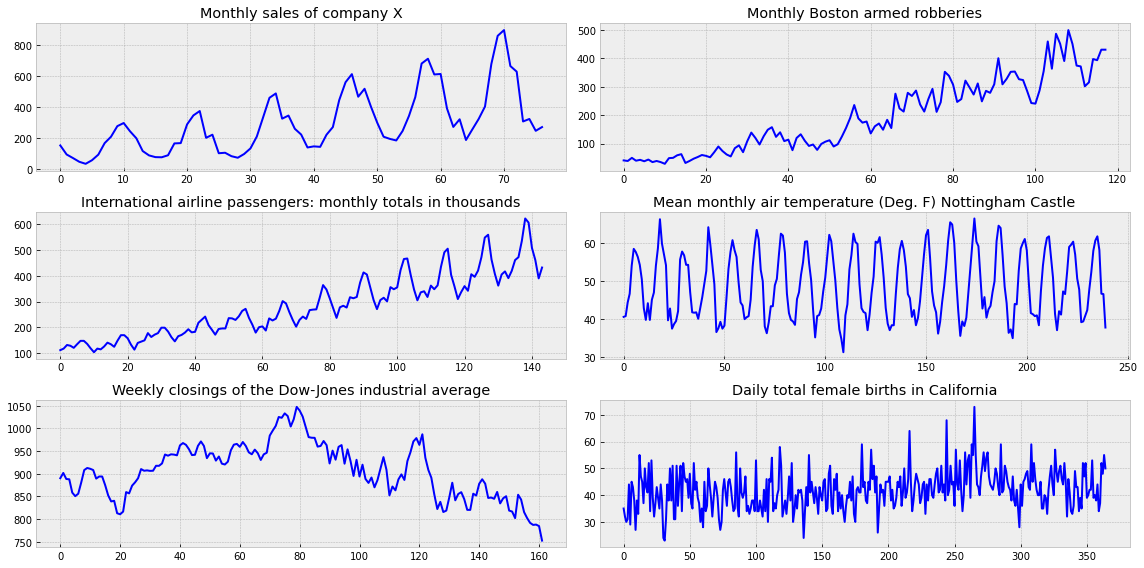

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Нормализуем дисперсию

In [9]:
from scipy.stats import boxcox

In [10]:
all_series = {series:boxcox(all_series[series], 0) for series in all_series}

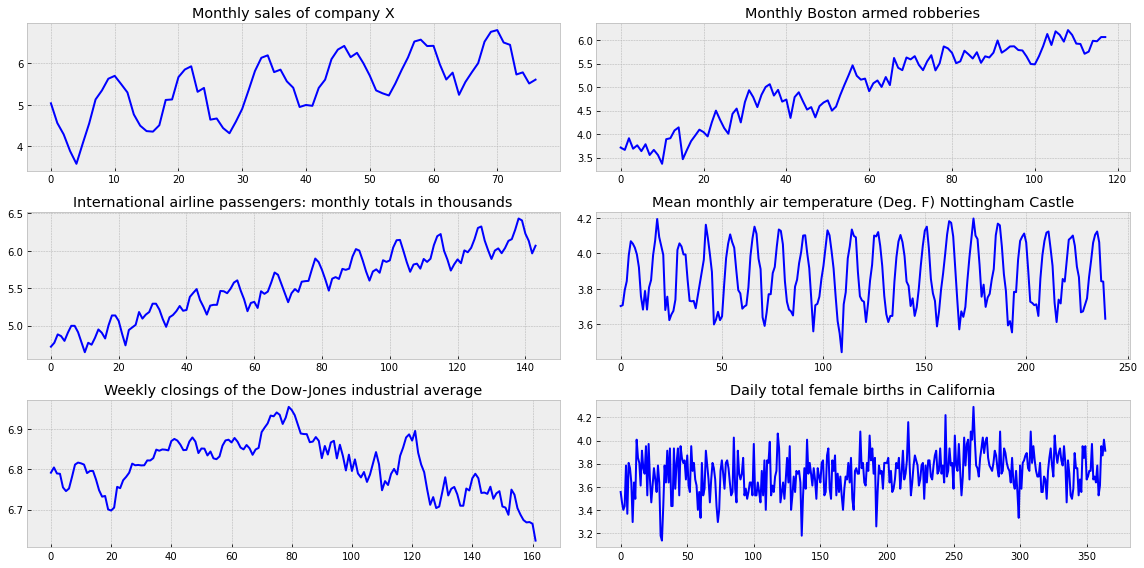

In [11]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        plt.plot(all_series[key], color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Дифференцируем 

In [13]:
import numpy as np

In [15]:
all_series = {series:np.diff(all_series[series], 1) for series in all_series}

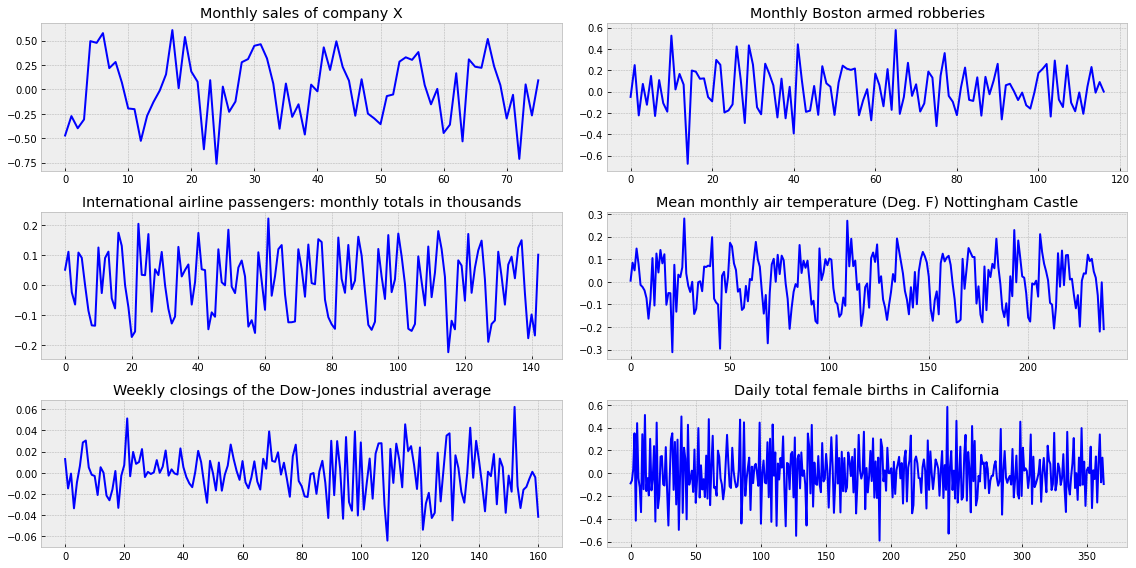

In [16]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        plt.plot(all_series[key], color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Тест Дики-Фуллера 

In [17]:
from statsmodels.tsa.stattools import adfuller

In [31]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    #for [key, value] in dftest[4].items():
       # dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if (dfoutput['p-value'] <= 0.05):
        print("TEST PASSED!")
    else:
        print("TEST NOT PASSED")

In [32]:
for series in all_series:
    print(series)
    test_stationarity(all_series[series])

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
dtype: float64
TEST PASSED!
Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
dtype: float64
TEST PASSED!
International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
dtype: float64
TEST NOT PASSED
Mean monthly air temperature (Deg. F) Nottingham Castle
Results of Dickey-Fuller Test:
Test Statistic                -1.214226e+01
p-value                        1.640728e-22
#Lags Used       

Тест Дики-Фуллера пройден для всех рядов, кроме ряда о пассажирах. p-value здесь очень близко к порогу. Выведем коррелограмму для этого ряда.

In [35]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [44]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [33]:
series = all_series['International airline passengers: monthly totals in thousands']

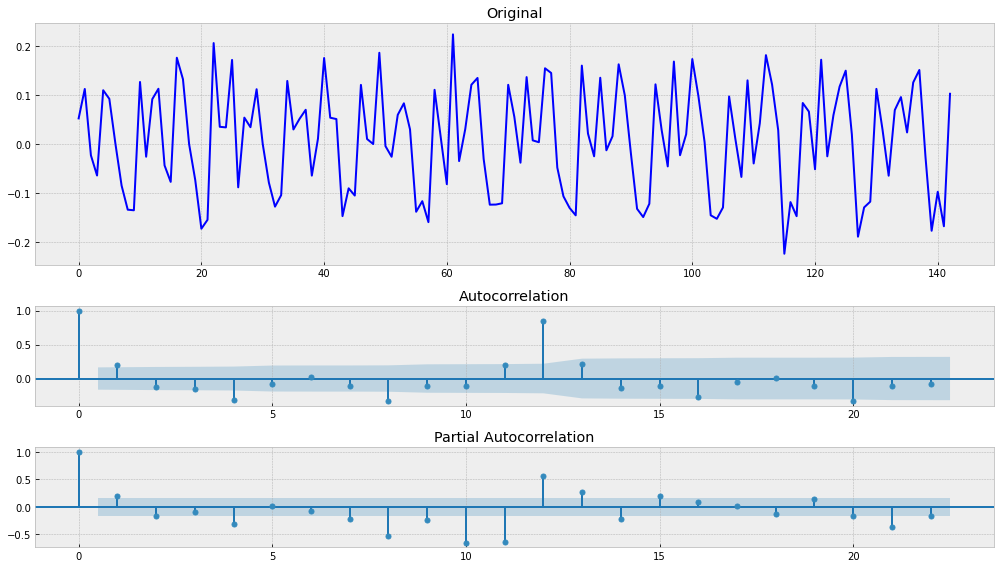

In [47]:
tsplot(series)

По коррелограмме видим влияние сезонности. Уберём её, продифференцировав ряд ещё раз.

In [49]:
series = np.diff(series, 12)

D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


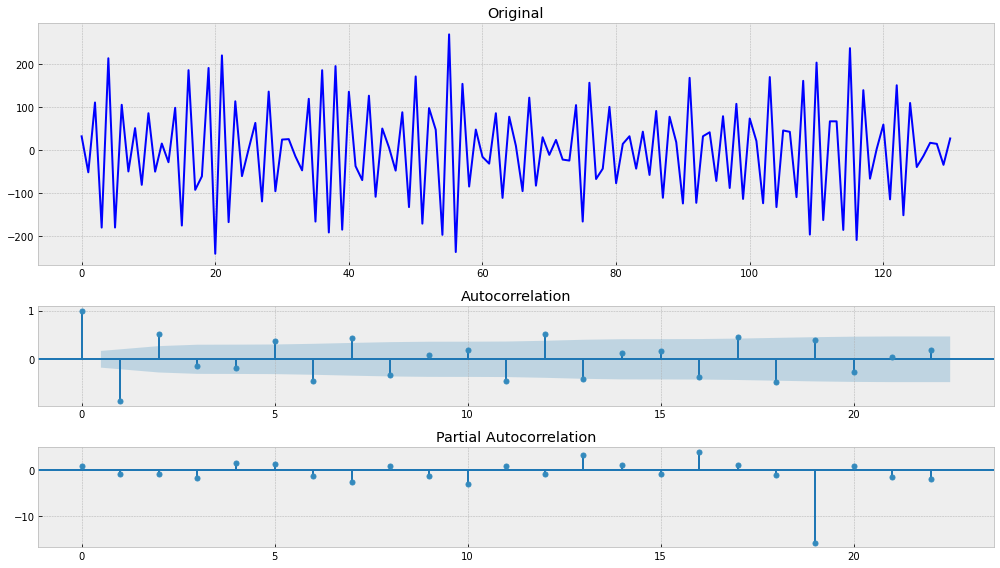

In [51]:
tsplot(series)

In [52]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.609085e+01
p-value                        5.255378e-29
#Lags Used                     1.300000e+01
Number of Observations Used    1.170000e+02
dtype: float64
TEST PASSED!


Теперь тест ДФ отвергает гипотезу о нестанционарности ряда, а значит, сам ряд стационарен.